In [102]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [3]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [4]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]
# load mtor, we want to remember source of data and Standard and pChEMBLE value (it's transfomed compound activity to "standard" value)
with open("VDR_IC50.csv") as inp:
    vdr = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in vdr:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "vdr"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [5]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = []
for m in Chem.SDMolSupplier("cdd2021/data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": 0,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })


In [6]:
df = pd.DataFrame((*drugbank, *[m for m in vdr if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,Standard Value,pChEMBL Value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f68bab03ee0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8f47b0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,29,...,0,0,3,3,0,0,0,0,0,0
1,1,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f68ec41a7b0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8f4ad0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,16,...,0,0,4,2,0,0,0,0,2,1
2,2,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8f4b70>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8f4ee0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.00,15,...,0,0,1,2,0,0,0,1,0,0
3,3,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8f4f80>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8f4e90>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,16,...,0,0,1,5,0,0,0,0,2,1
4,4,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8f4df0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8f4990>,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.00,12,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6785,6785,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8eff80>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed350>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",2880.00,5.54,6,...,0,0,1,2,0,0,0,0,0,0
6786,6786,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed3f0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed760>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",660.00,6.18,6,...,0,0,1,2,0,0,0,0,0,0
6787,6787,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed800>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edb70>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.13,8.95,3,...,0,0,1,2,0,0,0,0,2,1
6788,6788,CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...,CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edc10>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edf80>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",295.80,6.53,5,...,0,0,1,1,0,0,0,0,0,0


In [7]:
df = df[df['source']=='vdr']

In [8]:

df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,Standard Value,pChEMBL Value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6147,6147,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68bab0ba80>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba9834e0>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",9.30,8.03,5,...,0,0,2,2,0,0,0,0,2,1
6148,6148,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba983b20>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba983e90>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",6.00,8.22,4,...,0,0,2,2,0,0,0,0,2,1
6149,6149,C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)...,C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba983f30>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba986300>,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",150000.00,0.00,3,...,0,0,1,3,0,0,0,0,6,3
6150,6150,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@@...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@@...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba9863a0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba986710>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,3,...,0,0,1,2,0,0,0,0,2,1
6151,6151,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@@...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@@...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba9867b0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba986b20>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,3,...,0,0,1,2,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6785,6785,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8eff80>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed350>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",2880.00,5.54,6,...,0,0,1,2,0,0,0,0,0,0
6786,6786,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed3f0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed760>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",660.00,6.18,6,...,0,0,1,2,0,0,0,0,0,0
6787,6787,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed800>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edb70>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.13,8.95,3,...,0,0,1,2,0,0,0,0,2,1
6788,6788,CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...,CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edc10>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edf80>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",295.80,6.53,5,...,0,0,1,1,0,0,0,0,0,0


In [9]:
df = df.rename(columns={'pChEMBL Value':'p_value', 'Standard Value':'std_value',
                       })

In [10]:
len(df)

643

In [11]:
len(df[df['p_value'] > 0])
len(df[df['std_value'] > 0])

571

-Můj dataset ma 643 ligandu

-Z nich 423 ligandy maji p_value

-Znich 571 ligandu maji standard value

In [12]:
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,std_value,p_value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6147,6147,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68bab0ba80>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba9834e0>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",9.30,8.03,5,...,0,0,2,2,0,0,0,0,2,1
6148,6148,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba983b20>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba983e90>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",6.00,8.22,4,...,0,0,2,2,0,0,0,0,2,1
6149,6149,C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)...,C[C@H](CCC(=O)O)[C@H]1CC[C@H]2[C@@H]3[C@@H](O)...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba983f30>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba986300>,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",150000.00,0.00,3,...,0,0,1,3,0,0,0,0,6,3
6150,6150,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@@...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@@...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba9863a0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba986710>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,3,...,0,0,1,2,0,0,0,0,2,1
6151,6151,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@@...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@@...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba9867b0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba986b20>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,3,...,0,0,1,2,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6785,6785,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8eff80>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed350>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",2880.00,5.54,6,...,0,0,1,2,0,0,0,0,0,0
6786,6786,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed3f0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed760>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",660.00,6.18,6,...,0,0,1,2,0,0,0,0,0,0
6787,6787,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed800>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edb70>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.13,8.95,3,...,0,0,1,2,0,0,0,0,2,1
6788,6788,CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...,CCN(CC)CCCNC(=O)c1ccc(C(CC)(CC)c2ccc(OCCC(O)(C...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edc10>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edf80>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",295.80,6.53,5,...,0,0,1,1,0,0,0,0,0,0


# Random Forest

uděláme nejprve Random Forest a pro predikci pouyijeme sloupec fps, kde jsou uložene Morganové Fingerprinty do vektoru delky 1024 a taku použijeme MQN
Rozdelíme na testovaci, trenovaci a validacni set
Najdeme hzper parametry které ksou dobrý pro nas model

## Morganuv fingerprint

In [13]:
data = df[['fps', 'p_value']]
data = data[data['p_value']>0]
data

,fps,p_value
6147,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.03
6148,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",8.22
6152,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.81
6155,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.25
6157,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.85
...,...,...
6784,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.39
6785,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",5.54
6786,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.18
6787,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.95


In [14]:
n_splits = 5

X_train, X_test, y_train, y_test = train_test_split(data['fps'],data['p_value'] ,test_size=0.2, random_state=0)  


kf = KFold(n_splits = n_splits, shuffle=True, random_state=0)
a = -1 

param_gridRan = {
    "n_estimators": range(1,100,5),
    "max_depth": range(1,10)
}

mse = 1
for trains, valids in kf.split(X_train, y_train):
    a = a+1
    train_x = X_train.iloc[trains].tolist()
    train_y = y_train.iloc[trains].tolist()
    valid_x = X_train.iloc[valids].tolist()
    valid_y = y_train.iloc[valids].tolist()
    
    
    param_comb = ParameterGrid(param_gridRan)
    for params in param_comb:
        rfc = RandomForestRegressor(**params)
        rfc = rfc.fit(train_x,train_y)
        pre_rfc = rfc.predict(valid_x)

        mse1=  mean_squared_error(valid_y, rfc.predict(valid_x))
        if mse > mse1:
            mse = mse1
            opt_param = params

print("Valid MSE", mse)
print("Optimalni_parametr pro Random Forest", opt_param)   

Valid MSE 0.16974438498753064
Optimalni_parametr pro Random Forest {'max_depth': 8, 'n_estimators': 26}


Ted natrenujeme nas model s optimalnimi parametry

In [15]:
X = X_train.tolist()
y = y_train.tolist()

x_pred = X_test.tolist()
y_real = y_test.tolist()

rfr = RandomForestRegressor(**opt_param)
rfr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, rfc.predict(x_pred)))
print("Regressor score:", rfr.score(x_pred, y_real))
print("R^2", r2_score(y_real, rfc.predict(x_pred)))

Test MSE
MSE: 0.24
Regressor score: 0.9159073337358085
R^2 0.9122479795994244


In [16]:
test = pd.DataFrame()
test['Prediction'] = rfc.predict(x_pred)
test['Real'] = y_real
test

,Prediction,Real
0,4.809110,4.96
1,8.369304,7.46
2,5.090534,5.54
3,4.717008,4.40
4,8.139434,8.21
...,...,...
80,9.129751,9.92
81,4.791888,4.85
82,8.087661,8.11
83,5.116415,5.80


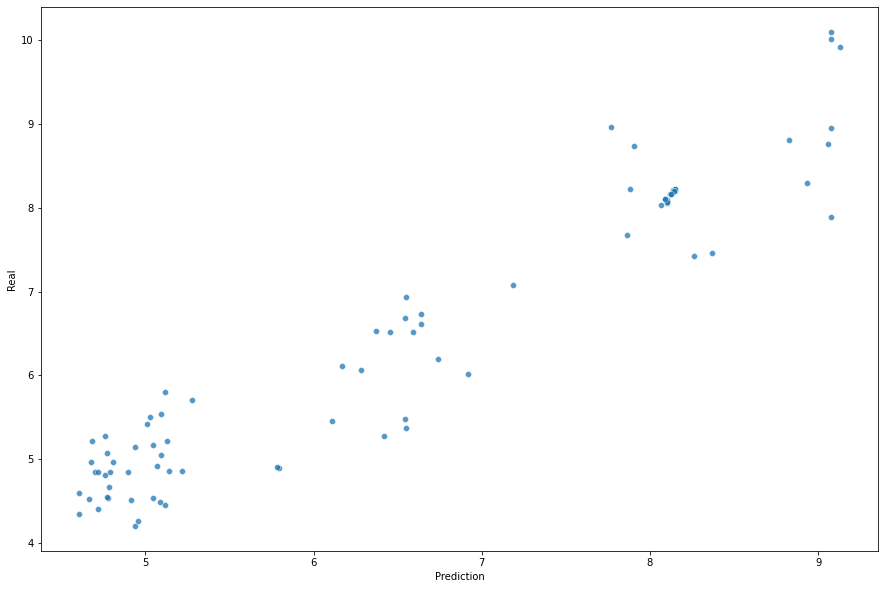

In [17]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Real",
                      data=test,                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## MQN

In [46]:
df = df[df['p_value']>0]
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,std_value,p_value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6147,6147,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68bab0ba80>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba9834e0>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",9.30,8.03,5,...,0,0,2,2,0,0,0,0,2,1
6148,6148,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba983b20>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba983e90>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",6.00,8.22,4,...,0,0,2,2,0,0,0,0,2,1
6152,6152,C=C1[C@H](O)CC(=C/C=C2\CCC[C@@]3(C)[C@H]2CC[C@...,C=C1[C@H](O)CC(=C/C=C2\CCC[C@@]3(C)[C@H]2CC[C@...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba986bc0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba986f30>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.55,8.81,3,...,0,0,1,2,0,0,0,0,2,1
6155,6155,COC(=O)c1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)c1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba989850>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba989bc0>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5670.00,5.25,6,...,0,0,1,2,0,0,0,0,0,0
6157,6157,COc1ncccc1C(Nc1ccc(Cl)cc1)c1c(C)[nH]c2ccccc12,COc1ncccc1C(Nc1ccc(Cl)cc1)c1c(C)[nH]c2ccccc12,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba98d0d0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba98d440>,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14200.00,4.85,3,...,0,0,1,3,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,6784,COc1cccc(-c2nc(C)c(COc3ccccc3C(=O)O)o2)c1,COc1cccc(-c2nc(C)c(COc3ccccc3C(=O)O)o2)c1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8efb70>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8efee0>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40400.00,4.39,5,...,0,0,1,2,0,0,0,0,0,0
6785,6785,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8eff80>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed350>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",2880.00,5.54,6,...,0,0,1,2,0,0,0,0,0,0
6786,6786,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed3f0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed760>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",660.00,6.18,6,...,0,0,1,2,0,0,0,0,0,0
6787,6787,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed800>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edb70>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.13,8.95,3,...,0,0,1,2,0,0,0,0,2,1


In [47]:
a = ['MQN_{}'.format(x) for x in range(1,43)]


In [48]:
data_mqn = df[a]
data_mqn

,MQN_1,MQN_2,MQN_3,MQN_4,MQN_5,MQN_6,MQN_7,MQN_8,MQN_9,MQN_10,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6147,34,0,0,0,0,0,0,0,0,4,...,0,0,2,2,0,0,0,0,2,1
6148,29,0,0,0,0,0,0,0,0,3,...,0,0,2,2,0,0,0,0,2,1
6152,30,0,0,0,0,0,0,0,0,3,...,0,0,1,2,0,0,0,0,2,1
6155,20,0,0,0,0,0,0,0,1,4,...,0,0,1,2,0,0,0,0,0,0
6157,22,0,1,0,0,0,0,1,2,1,...,0,0,1,3,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,19,0,0,0,0,0,0,0,1,4,...,0,0,1,2,0,0,0,0,0,0
6785,22,0,0,0,0,0,0,0,1,4,...,0,0,1,2,0,0,0,0,0,0
6786,21,0,0,0,0,0,0,0,1,4,...,0,0,1,2,0,0,0,0,0,0
6787,27,0,0,0,0,0,0,0,0,3,...,0,0,1,2,0,0,0,0,2,1


In [49]:
data_p = df[['p_value']]
data_p

,p_value
6147,8.03
6148,8.22
6152,8.81
6155,5.25
6157,4.85
...,...
6784,4.39
6785,5.54
6786,6.18
6787,8.95


In [50]:
X = data_mqn
y = data_p

In [51]:
n_splits = 5

X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.2, random_state=0)  


kf = KFold(n_splits = n_splits, shuffle=True, random_state=0)
a = -1 

param_gridRan = {
    "n_estimators": range(1,100,5),
    "max_depth": range(1,10)
}

mse = 1
for trains, valids in kf.split(X_train, y_train):
    a = a+1
    train_x = X_train.iloc[trains]
    train_y = y_train.iloc[trains]
    valid_x = X_train.iloc[valids]
    valid_y = y_train.iloc[valids]
    
    
    param_comb = ParameterGrid(param_gridRan)
    for params in param_comb:
        rfc = RandomForestRegressor(**params)
        rfc = rfc.fit(train_x,train_y)
        pre_rfc = rfc.predict(valid_x)

        mse1=  mean_squared_error(valid_y, rfc.predict(valid_x))
        if mse > mse1:
            mse = mse1
            opt_param = params

print("Valid MSE", mse)
print("Optimalni_parametr pro Random Forest", opt_param)   

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(train_x,train_y)
<ipython-input-51-c2acfac4abc0>:26: DataConversionWarning: A column-vector y was passed when a 1d array 

Valid MSE 0.22612006260490933
Optimalni_parametr pro Random Forest {'max_depth': 7, 'n_estimators': 6}


In [52]:
y_test

,p_value
6385,4.96
6181,7.46
6785,5.54
6163,4.40
6299,8.21
...,...
6734,9.92
6157,4.85
6526,8.11
6507,5.80


In [53]:
X = X_train
y = y_train

x_pred = X_test
y_real = y_test

rfr = RandomForestRegressor(**opt_param)
rfr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, rfc.predict(x_pred)))
print("Regressor score:", rfr.score(x_pred, y_real))
print("R^2", r2_score(y_real, rfc.predict(x_pred)))

Test MSE
MSE: 0.47
Regressor score: 0.8367488040387849
R^2 0.8271561392830319


<ipython-input-53-7a91c5b43c39>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X, y)


In [54]:
y_real = y_real.to_numpy()


In [55]:
test = pd.DataFrame()
test['Prediction'] = rfc.predict(x_pred)
test['Real'] = y_real
test


,Prediction,Real
0,7.244864,4.96
1,8.899970,7.46
2,5.017656,5.54
3,6.969842,4.40
4,8.150668,8.21
...,...,...
80,8.990882,9.92
81,4.842679,4.85
82,7.950195,8.11
83,5.092778,5.80


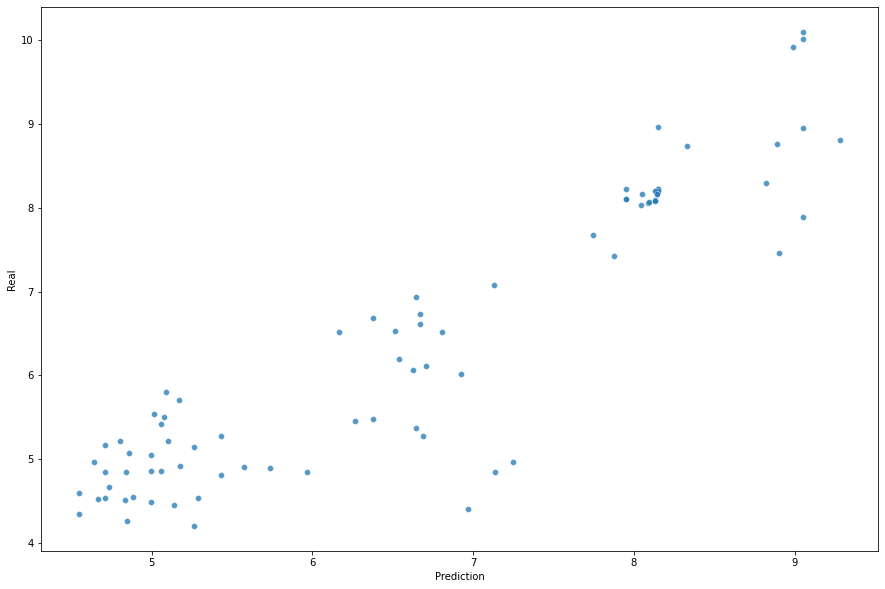

In [56]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Real",
                      data=test,                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Predikce vysla lepsi pro Random Forest s Morganovymi fingerprinty

# SVR

## Morganuv fingerprint

In [82]:
df = df[df['p_value']>0]
data = df[['fps', 'p_value']]
data = data[data['p_value']>0]
data

,fps,p_value
6147,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.03
6148,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",8.22
6152,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.81
6155,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.25
6157,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.85
...,...,...
6784,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.39
6785,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",5.54
6786,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.18
6787,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.95


In [83]:
svr = svm.SVR(kernel = 'linear')

In [84]:
n_splits = 5

X_train, X_test, y_train, y_test = train_test_split(data['fps'],data['p_value'] ,test_size=0.2, random_state=0)  


kf = KFold(n_splits = n_splits, shuffle=True, random_state=0)
a = -1 

param_gridSVR = {
    "kernel":['linear', 'poly', 'rbf', 'sigmoid']
}

mse = 1
for trains, valids in kf.split(X_train, y_train):
    a = a+1
    train_x = X_train.iloc[trains].tolist()
    train_y = y_train.iloc[trains].tolist()
    valid_x = X_train.iloc[valids].tolist()
    valid_y = y_train.iloc[valids].tolist()
    
    
    param_comb = ParameterGrid(param_gridSVR)
    for params in param_comb:
        
        svr = svm.SVR(**params)
        svr = svr.fit(train_x,train_y)
        pre_svr = svr.predict(valid_x)

        mse1=  mean_squared_error(valid_y, svr.predict(valid_x))
        if mse > mse1:
            mse = mse1
            opt_param = params

print("Valid MSE", mse)
print("Optimalni_parametr pro Random Forest", opt_param)   

Valid MSE 0.20304706003579284
Optimalni_parametr pro Random Forest {'kernel': 'linear'}


In [85]:
X = X_train.tolist()
y = y_train.tolist()

x_pred = X_test.tolist()
y_real = y_test.tolist()

svr = svm.SVR(**opt_param)
svr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, svr.predict(x_pred)))
print("Regressor score:", svr.score(x_pred, y_real))
print("R^2", r2_score(y_real, svr.predict(x_pred)))

Test MSE
MSE: 0.33
Regressor score: 0.880211267196185
R^2 0.880211267196185


In [86]:
test = pd.DataFrame()
test['Prediction'] = rfc.predict(x_pred)
test['Real'] = y_real
test

,Prediction,Real
0,4.836398,4.96
1,8.448007,7.46
2,5.084041,5.54
3,4.699181,4.40
4,8.141955,8.21
...,...,...
80,9.148274,9.92
81,4.881659,4.85
82,8.103084,8.11
83,5.111926,5.80


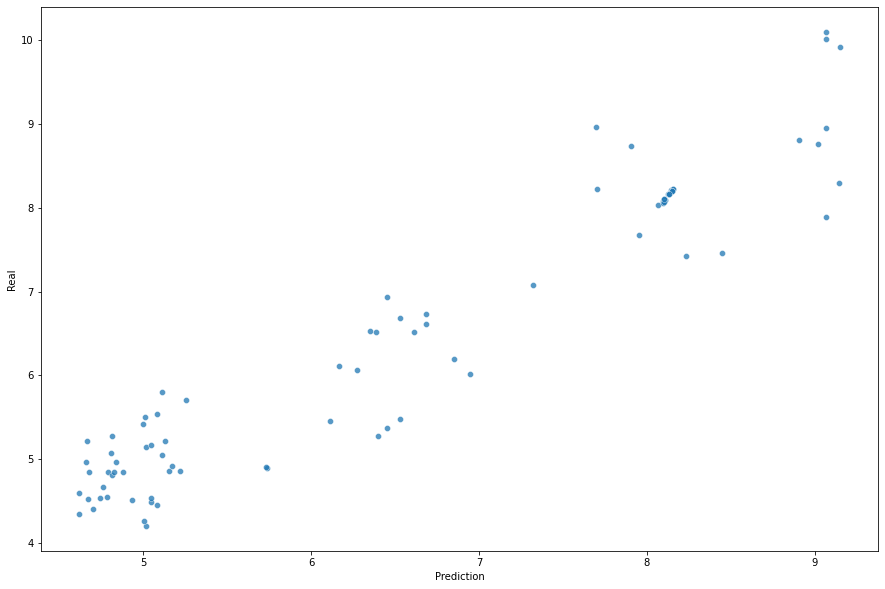

In [87]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Real",
                      data=test,                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## MQN

In [88]:
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,std_value,p_value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6147,6147,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68bab0ba80>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba9834e0>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",9.30,8.03,5,...,0,0,2,2,0,0,0,0,2,1
6148,6148,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba983b20>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba983e90>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",6.00,8.22,4,...,0,0,2,2,0,0,0,0,2,1
6152,6152,C=C1[C@H](O)CC(=C/C=C2\CCC[C@@]3(C)[C@H]2CC[C@...,C=C1[C@H](O)CC(=C/C=C2\CCC[C@@]3(C)[C@H]2CC[C@...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba986bc0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba986f30>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.55,8.81,3,...,0,0,1,2,0,0,0,0,2,1
6155,6155,COC(=O)c1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)c1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba989850>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba989bc0>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5670.00,5.25,6,...,0,0,1,2,0,0,0,0,0,0
6157,6157,COc1ncccc1C(Nc1ccc(Cl)cc1)c1c(C)[nH]c2ccccc12,COc1ncccc1C(Nc1ccc(Cl)cc1)c1c(C)[nH]c2ccccc12,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba98d0d0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba98d440>,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14200.00,4.85,3,...,0,0,1,3,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,6784,COc1cccc(-c2nc(C)c(COc3ccccc3C(=O)O)o2)c1,COc1cccc(-c2nc(C)c(COc3ccccc3C(=O)O)o2)c1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8efb70>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8efee0>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40400.00,4.39,5,...,0,0,1,2,0,0,0,0,0,0
6785,6785,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)CCc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8eff80>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed350>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",2880.00,5.54,6,...,0,0,1,2,0,0,0,0,0,0
6786,6786,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,COC(=O)Cc1ccc(OCc2oc(-c3cccc(OC)c3)nc2C)cc1,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed3f0>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed760>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",660.00,6.18,6,...,0,0,1,2,0,0,0,0,0,0
6787,6787,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,C=C1/C(=C\C=C2/CCC[C@]3(C)C(C(C)CCCC(C)(C)O)CC...,vdr,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8ed800>,<rdkit.Chem.rdchem.Mol object at 0x7f68ba8edb70>,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.13,8.95,3,...,0,0,1,2,0,0,0,0,2,1


In [89]:
a = ['MQN_{}'.format(x) for x in range(1,43)]


In [90]:
data_mqn = df[a]
data_mqn

,MQN_1,MQN_2,MQN_3,MQN_4,MQN_5,MQN_6,MQN_7,MQN_8,MQN_9,MQN_10,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
6147,34,0,0,0,0,0,0,0,0,4,...,0,0,2,2,0,0,0,0,2,1
6148,29,0,0,0,0,0,0,0,0,3,...,0,0,2,2,0,0,0,0,2,1
6152,30,0,0,0,0,0,0,0,0,3,...,0,0,1,2,0,0,0,0,2,1
6155,20,0,0,0,0,0,0,0,1,4,...,0,0,1,2,0,0,0,0,0,0
6157,22,0,1,0,0,0,0,1,2,1,...,0,0,1,3,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,19,0,0,0,0,0,0,0,1,4,...,0,0,1,2,0,0,0,0,0,0
6785,22,0,0,0,0,0,0,0,1,4,...,0,0,1,2,0,0,0,0,0,0
6786,21,0,0,0,0,0,0,0,1,4,...,0,0,1,2,0,0,0,0,0,0
6787,27,0,0,0,0,0,0,0,0,3,...,0,0,1,2,0,0,0,0,2,1


In [91]:
data_p = df[['p_value']]
data_p

,p_value
6147,8.03
6148,8.22
6152,8.81
6155,5.25
6157,4.85
...,...
6784,4.39
6785,5.54
6786,6.18
6787,8.95


In [92]:
X = data_mqn
y = data_p

In [97]:
n_splits = 5

X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.2, random_state=0)  


kf = KFold(n_splits = n_splits, shuffle=True, random_state=0)
a = -1 

param_gridSVR = {
    "kernel":['linear', 'poly', 'rbf', 'sigmoid']
}

mse = 1
for trains, valids in kf.split(X_train, y_train):
    a = a+1
    train_x = X_train.iloc[trains]
    train_y = y_train.iloc[trains]
    valid_x = X_train.iloc[valids]
    valid_y = y_train.iloc[valids]
    
    
    param_comb = ParameterGrid(param_gridSVR)
    for params in param_comb:
        
        svr = svm.SVR(**params)
        svr = svr.fit(train_x,train_y)
        pre_svr = svr.predict(valid_x)

        mse1=  mean_squared_error(valid_y, svr.predict(valid_x))
        if mse > mse1:
            mse = mse1
            opt_param = params

print("Valid MSE", mse)
print("Optimalni_parametr pro Random Forest", opt_param)   

/home/valeriia/anaconda3/envs/pnl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/valeriia/anaconda3/envs/pnl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/valeriia/anaconda3/envs/pnl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/valeriia/anaconda3/envs/pnl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

Valid MSE 0.3513511139301391
Optimalni_parametr pro Random Forest {'kernel': 'linear'}


/home/valeriia/anaconda3/envs/pnl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/valeriia/anaconda3/envs/pnl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/valeriia/anaconda3/envs/pnl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/valeriia/anaconda3/envs/pnl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was 

In [98]:
X = X_train
y = y_train

x_pred = X_test
y_real = y_test

svr = svm.SVR(**opt_param)
svr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, svr.predict(x_pred)))
print("Regressor score:", svr.score(x_pred, y_real))
print("R^2", r2_score(y_real, svr.predict(x_pred)))

Test MSE
MSE: 0.35
Regressor score: 0.8659790510304871
R^2 0.8659790510304871


/home/valeriia/anaconda3/envs/pnl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [99]:
y_real = y_real.to_numpy()


In [100]:
test = pd.DataFrame()
test['Prediction'] = svr.predict(x_pred)
test['Real'] = y_real
test


,Prediction,Real
0,4.540680,5.14
1,7.929581,8.03
2,4.620368,4.52
3,8.595524,9.39
4,6.755675,7.15
5,4.838381,4.50
6,4.838381,5.09
7,4.649856,4.95
8,5.100672,5.47
9,7.648366,7.77


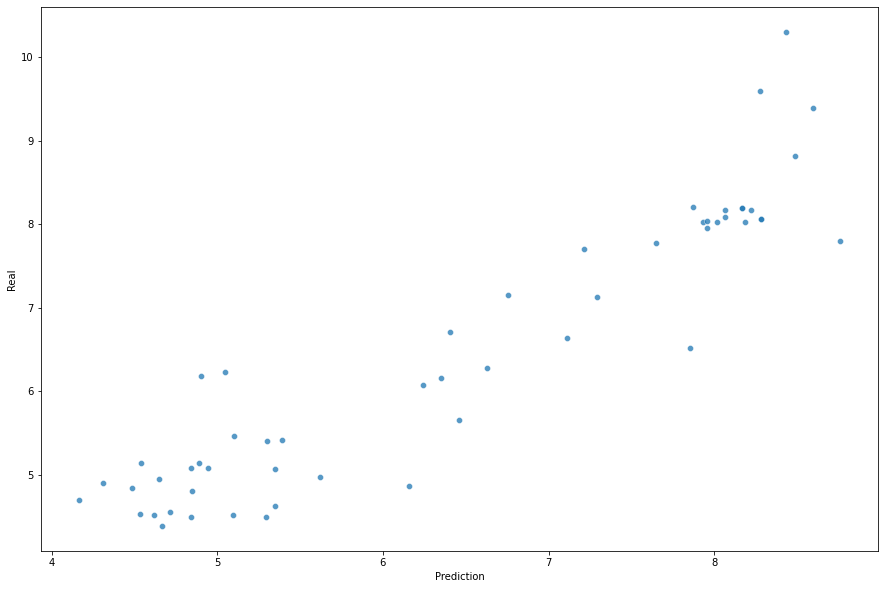

In [101]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Real",
                      data=test,                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

V tomot pripade u SVR taky vyslo lespi predikce u Morganova fingerptintu

# AdaBoost

In [104]:
data = df[['fps', 'p_value']]
data

,fps,p_value
6147,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.03
6148,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",8.22
6152,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.81
6155,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.25
6157,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.85
...,...,...
6784,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.39
6785,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",5.54
6786,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.18
6787,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",8.95


In [106]:
X_train, X_test, y_train, y_test = train_test_split(data['fps'],data['p_value'] ,test_size=0.2, random_state=0)  


In [107]:


X = X_train.tolist()
y = y_train.tolist()

x_pred = X_test.tolist()
y_real = y_test.tolist()

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X, y)

print("Test MSE")
print("MSE: %0.2f" % mean_squared_error(y_real, regr.predict(x_pred)))
print("Regressor score:", regr.score(x_pred, y_real))
print("R^2", r2_score(y_real, regr.predict(x_pred)))

Test MSE
MSE: 0.34
Regressor score: 0.8757545141361357
R^2 0.8757545141361357


In [110]:
test = pd.DataFrame()
test['Prediction'] = regr.predict(x_pred)
test['Real'] = y_real
test


,Prediction,Real
0,4.964496,4.96
1,7.897264,7.46
2,4.988033,5.54
3,4.964496,4.40
4,7.897264,8.21
...,...,...
80,8.686552,9.92
81,4.964496,4.85
82,7.897264,8.11
83,4.988033,5.80


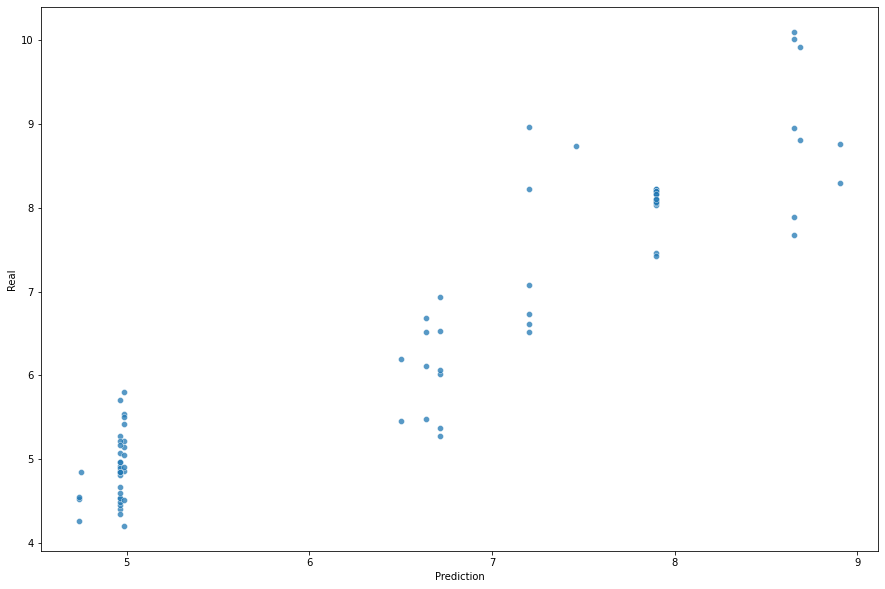

In [111]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Real",
                      data=test,                      
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Nejlepsi model je Random forest s morganovymi fingerprinty